In [1]:
%cd '../..'

/home/tyz910/src/sberbank-covid19


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from util.data import read_data
from util.model_lgb import predict_lgb_iterate
from util.model_decay import predict_decay

PREDICT_DAYS = 7
ITERATE_DAYS = 3
DECAY_DAYS = 90
END_DATE = '2020-12-31'

LGB_PARAMS = {
    'num_boost_round': 200,
    'learning_rate': 0.05,
    'max_depth': 3,
    'regions_weight': 1.0,
}

countries, data = read_data(update=True)
data.head()

confirmed.csv loaded
deaths.csv loaded
confirmed_ru.csv loaded
deaths_ru.csv loaded


,date,country,confirmed,deaths
0,2020-02-24,AFG,1,0
1,2020-02-25,AFG,1,0
2,2020-02-26,AFG,1,0
3,2020-02-27,AFG,1,0
4,2020-02-28,AFG,1,0


# PREDICT

In [3]:
preds_lgb = predict_lgb_iterate(data, countries, LGB_PARAMS, PREDICT_DAYS, ITERATE_DAYS)

# decay
preds = preds_lgb.append(predict_decay(preds_lgb.rename(columns={
    'prediction_confirmed': 'confirmed',
    'prediction_deaths': 'deaths',
}), num_days=DECAY_DAYS, decay=1.0))

# fill it out
date = preds['date'].max()
last = preds[preds['date'] == date].reset_index(drop=True)
while True:
    date += pd.to_timedelta(1, unit='d')

    date_preds = last.copy()
    date_preds['date'] = date
    preds = preds.append(date_preds)

    if date.strftime("%Y-%m-%d") == END_DATE:
        break

preds = preds.sort_values(by=['country', 'date']).reset_index(drop=True)
preds.head()

,date,country,prediction_confirmed,prediction_deaths
0,2020-04-27,AFG,1604.431216,53.054733
1,2020-04-28,AFG,1710.548140,56.331221
2,2020-04-29,AFG,1816.121914,61.070423
3,2020-04-30,AFG,1905.498805,64.649067
4,2020-05-01,AFG,2040.041779,69.776562


# RESULTS

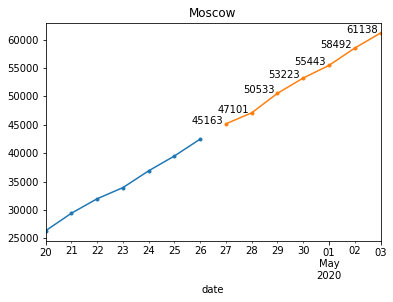

In [4]:
combined = pd.merge(data, preds_lgb, how='outer', on=['date', 'country'])

def plot_country(country, ax=None): 
    preds = combined[combined['country'] == country].set_index('date')
    ax = preds[['confirmed', 'prediction_confirmed']].tail(2 * PREDICT_DAYS).plot(
        title=countries.loc[country]['name'],
        legend=False,
        style='.-',
        ax=ax
    )

    for d, row in preds.iterrows():
        if row['prediction_confirmed'] > 0:
            val = row['prediction_confirmed']
            ax.annotate(round(val), (d, val), textcoords="offset points", xytext=(-3, 0), ha='right')

plot_country('RU-MOW')

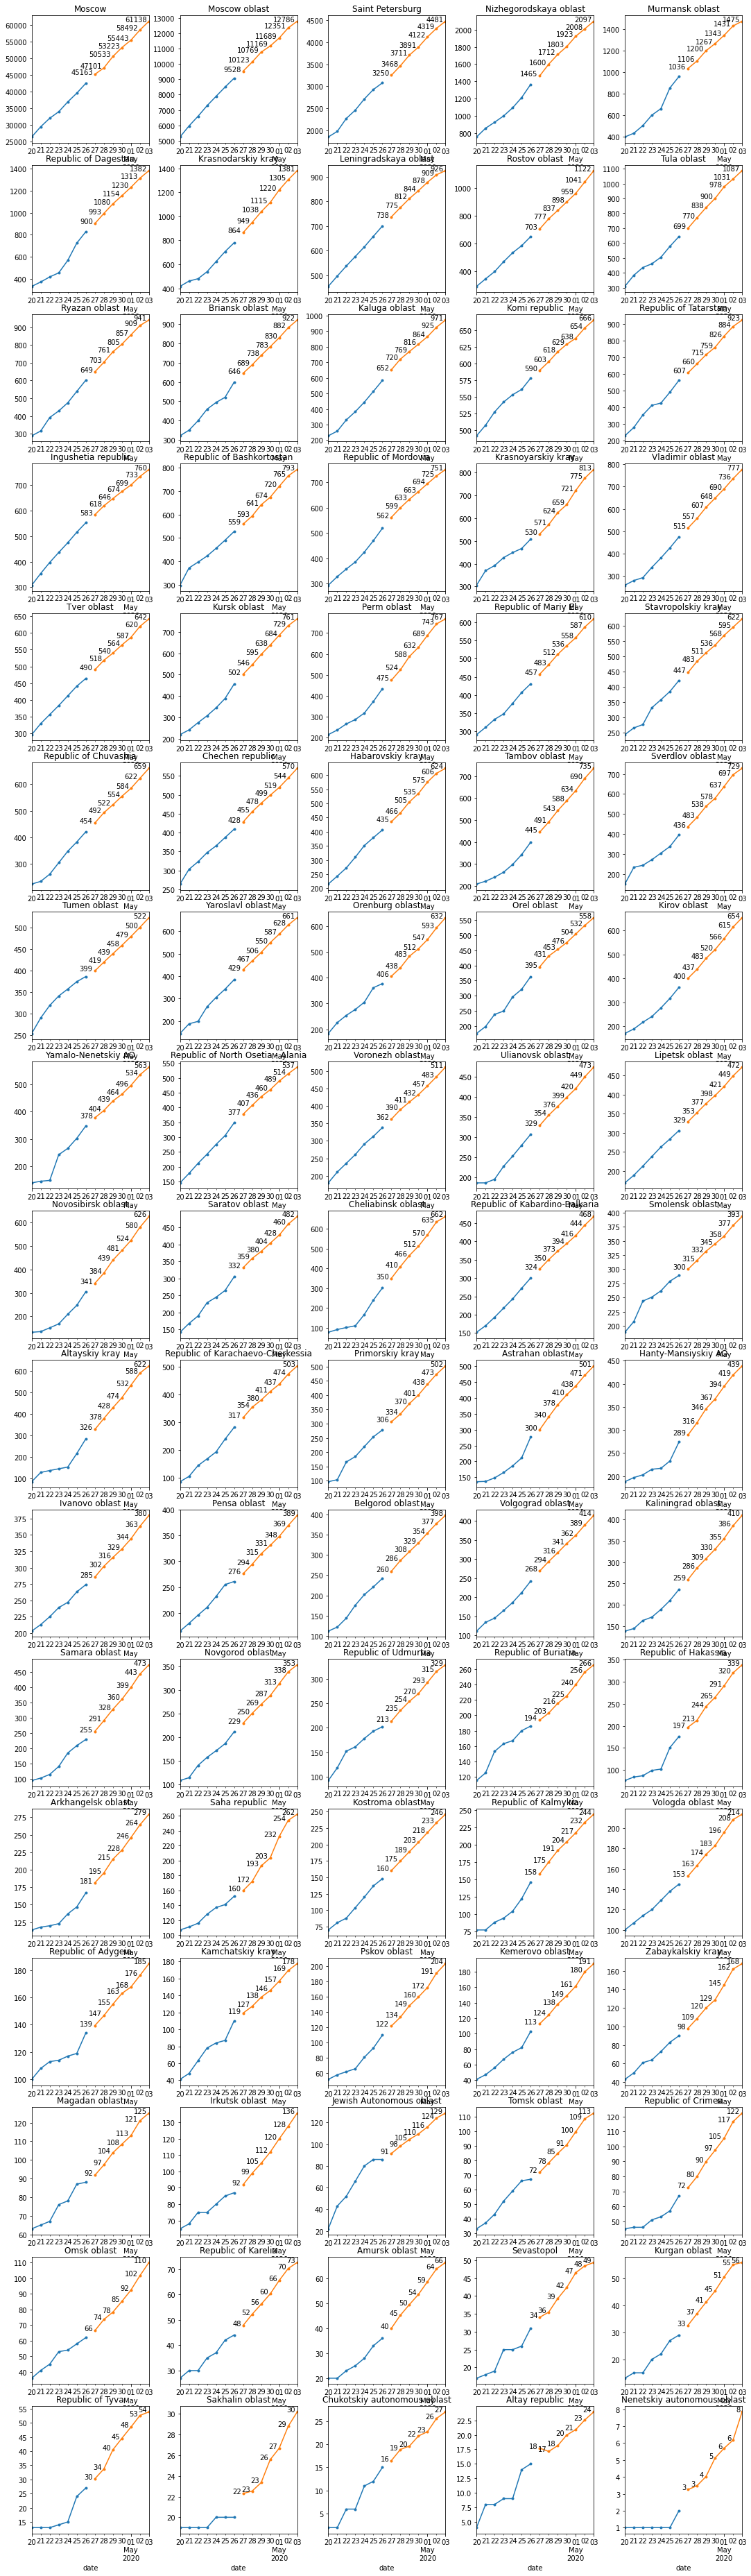

In [5]:
ncols = 5
nrows = 17

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3), squeeze=False)
fig.tight_layout()

axes = axes.reshape(-1)
ru_regions = countries[countries['is_region'] == 1].index
ru_regions = data[data['country'].isin(ru_regions)].groupby('country')['confirmed'].max().sort_values(ascending=False).index

for i, country in enumerate(ru_regions):
    plot_country(country, axes[i])

# SUBMIT

In [6]:
submit = preds.rename(columns={'country': 'region'}).copy()
submit[['prediction_confirmed', 'prediction_deaths']] = submit[['prediction_confirmed', 'prediction_deaths']].round().abs()
submit.to_csv('submission.csv', index=False)

submit.head()

,date,region,prediction_confirmed,prediction_deaths
0,2020-04-27,AFG,1604.0,53.0
1,2020-04-28,AFG,1711.0,56.0
2,2020-04-29,AFG,1816.0,61.0
3,2020-04-30,AFG,1905.0,65.0
4,2020-05-01,AFG,2040.0,70.0
